# Group Meeting 8

Functional and effective network inference 

### Readings 

Novelli and Lizier, 2020 https://arxiv.org/pdf/2007.07500.pdf

*Bonus Reading:*

Novelli et al., 2019 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6663300/


#### Functional & Effective Networks from Data

In complex systems science, we often do not have the underlying "map" of our system readily available to us and instead have to infer it's structure from observations about the real world: for example, in the brain it is (currently) impossible to extract the wiring diagram of even small patches of cortex, and in economic systems, the structure of interactions between firms is abstracted and contingent on external factors. Usually, instead of the underlying connectivity, we have time-series data that we record from the system of interest, and from that we can attempt to reconstruct the underlying causal structure of the system. 

There are three different ways to attempt to construct a network model of a system:

1) _Structural Connectivity_: This is the most "rigid" network model: it is assumed to remain static and is the "ground" that supports on-going dynamics. Here, elements of the system are treated as nodes and the edges between them are some kind of substrate that the dynamics play out "on top of". A classic example is the neural wiring diagram: physical neurons synapse onto each-other and action potentials transmit signals between them via neurotransmitter release. Another example would be the physical infrastructure of the Internet, or (slightly more abstracted), the network of hyperlinks that makes up the World Wide Web. 

Generally *hard* to infer from just time-series data, unless you can make certain assumptions. 

2) _Functional Connectivity_: This is the most abstract network model. Once again, elements of the system are nodes, but here edges are *undirected* and quantifiy some kind of undirected statistical dependence between the elements. The canonical model of functional connectivity is from fMRI data: a network of brain regions can be defined by mapping brain regions to nodes, and then the edges between them are given by linear Pearson correlation coefficients between them. Unlike structural connectivity which implies some kind of physical/causal process describing the system, the functional connectivity is purely correlational. 

Generally *easy* to infer from time-series data, although different methods can return wildly different results. 

The standard information-theoretic estimator is *mutual information* or *conditional mutual information*.

3) _Effective Connectivity_: Effective connectivity combines elements of structural connectivity and functional connectivity. Like structural connectivity, it is a *directed* relationship, but like functional connectivity it is a statistical description of the data rather than a *causal* one. I cannot oversate enough: *effective connectivity is NOT causal structure!* Many differnet causal structures can return the same effective connectivity. Effective connectivity can generally be understood as understanding how the state or behavior of one element of the system effects, or constrains, the future of another element of the system. 

Generally *hard* to infer from time-series data. 

The standard information-theoretic estimator is *transfer entropy* or *multivariate transfer entropy*

Under certain (unusual) circumstances, the effective connectivity *can* be identical to the structural connectivity although they are **not the same concept.** For a totally stationary process, with a huge amount of available data, the transfer entropy network 

### Functional Connectivity

"Classical" functional connectivty is done just by calculating the pairwise statistical dependence between all elements of the system (in this case, mutual information). This gives a measure of how mutually informative two elements of the system are about each-other, without providing any model of whether the interaction is directed or mediated by higher-order relationships. 

Pros: Very fast, easy to interpret. 

Cons: Bivariate nature makes it blind to synergies, specificities and redundancies in the dataset.

##### Significance Testing 

When doing functional or effective network inference using information theory, is generally considered to be *vitally* important to threshold your edges using a significance test. This is because information theoretic measures will almost always have a bias built in which results in numerical results that can be misleading. In the case of mutual information, the bias is always *over*-estimating the true mutual information. Consequently, just because you see a non-zero value doesn't mean that the effect can be assumed to be "real." 

There are two steps to testing bivariate mutual information (and TE) measures. 

1) Calculate your empirical MI. 

2) Create a large number of null time-series (be sure to preserve the number of spikes, autocorrelation, or whatever else might be important). 

3) Do a significance test: if p<$\alpha$, you can conclude a significant result and a "real" edge.

4) Subtract off the expected value (mean) of the null distribution to produce a *bias corrected MI estimate*.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns #Seaborn is a wrapper for matplotlib - it makes everything prettier.
sns.set(style="white")
from copy import deepcopy
from collections import Counter
from scipy.stats import zscore, entropy
import networkx as nx 

def mutual_information(X,Y):
    H_joint = entropy(list(Counter(zip(X,Y)).values()), base=2)
    H_X = entropy(list(Counter(X).values()), base=2)
    H_Y = entropy(list(Counter(Y).values()), base=2)
    return H_X + H_Y - H_joint

def conditional_mutual_information(X,Y,Z):
    H_XZ = entropy(list(Counter(zip(X,Z)).values()), base=2)
    H_YZ = entropy(list(Counter(zip(Y,Z)).values()), base=2)
    H_XYZ = entropy(list(Counter(zip(X,Y,Z)).values()), base=2)
    H_Z = entropy(list(Counter(Z).values()), base=2)
    return H_XZ + H_YZ - H_XYZ - H_Z

data = np.load("data/HCP_BOLD.npz")
bold = zscore(data["signal"], axis=1)
discrete = deepcopy(bold)
discrete[discrete > 0] = 1
discrete[discrete < 0] = 0
discrete = discrete.astype("int16")

### Significance Testing A Single Edge

Here is an example, consider two discretized BOLD time-series known to have a high mutual information:

In [2]:
empirical = mutual_information(discrete[4], discrete[5])
print("Empirical MI:", empirical, "bit")

null = np.zeros(10000)
for i in range(null.shape[0]):
    null_5 = deepcopy(discrete[5])
    np.random.shuffle(null_5)
    
    null[i] = mutual_information(discrete[5], null_5)

Empirical MI: 0.3320531969323486 bit


Expected Null: 0.0005991989090412982 bit


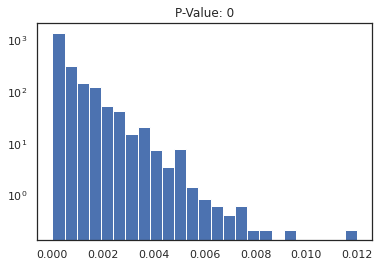

In [3]:
plt.hist(null, bins=25, density=True)
plt.yscale("log")
plt.title("P-Value: {0}".format(str(np.sum(null > empirical))))
print("Expected Null:", np.mean(null), "bit")

In [4]:
print("Bias-Corrected MI", empirical-np.mean(null), "bit")

Bias-Corrected MI 0.3314539980233073 bit


### Building An FC-Matrix 

Building the actual functional connectivity matrix is very easy: you just do a pairwise comparison of every combination i and j, and feed that into a matrix. 

*Note that, to save time, I am **not** significance-testing each edge or bias-correcting, this is just for demo purposes.*

In [5]:
mat = np.zeros((discrete.shape[0], discrete.shape[0]))

for i in range(discrete.shape[0]):
    for j in range(i): #Because mutual information is symmetric, you only need to fill the lower triangle.
        mi = mutual_information(discrete[i], discrete[j])
        mat[i][j] = mi 
        mat[j][i] = mi #MI(X,Y) = MI(Y,X), so you get two for the computational price of 1. 

Text(0.5, 1.0, 'Mutual Information Matrix (No Bias Correction)')

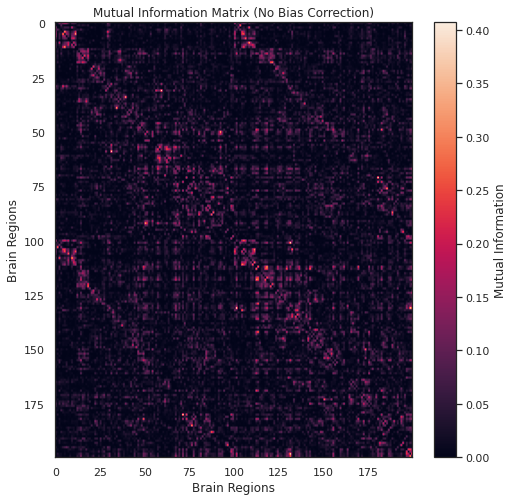

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(mat, aspect="auto")
plt.xlabel("Brain Regions")
plt.ylabel("Brain Regions")
plt.colorbar(label="Mutual Information")
plt.title("Mutual Information Matrix (No Bias Correction)")

### Scary Synergies

As we've previously discussed, a major problem with *all* pairwise network construction methods is that they can be blind to synergies and redundacies in the data. To review, consider this simple example of two random nodes, and then a third that is the instantanious exclusive-OR ($XOR$) between them:

Text(0.5, 1.0, 'True Generating Structure')

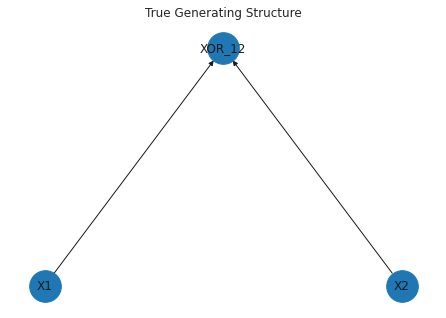

In [7]:
G = nx.DiGraph()
G.add_nodes_from(("X1","X2","XOR_12"))
G.add_edges_from((("X1","XOR_12"),("X2","XOR_12")))

nx.draw_spectral(G, with_labels=True, node_size=10**3)
plt.title("True Generating Structure")

In [8]:
X1 = np.random.randint(0,2,1200)
X2 = np.random.randint(0,2,1200)
print("MI(X1 ; X2)", mutual_information(X1, X2), "bit")
XOR_12 = np.logical_xor(X1, X2)
print("MI(X1 ; XOR_12)", mutual_information(X1, XOR_12), "bit")
print("MI(X2 ; XOR_12)", mutual_information(X2, XOR_12), "bit")

MI(X1 ; X2) 2.1755652197530395e-05 bit
MI(X1 ; XOR_12) 0.000246188389319002 bit
MI(X2 ; XOR_12) 0.0005167409381554577 bit


Doing the correction, we will see that these edges won't pass significance testing.

Expected Null: 0.000618991594602597 bit


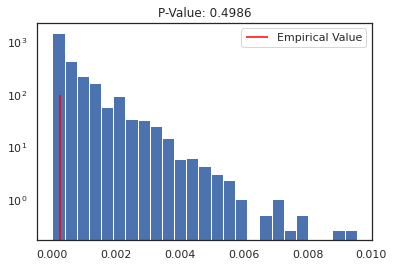

In [9]:
null = np.zeros(10000)
null_X1 = deepcopy(X1)
for i in range(null.shape[0]):
    np.random.shuffle(null_X1)
    null[i] = mutual_information(XOR_12, null_X1)

plt.hist(null, bins=25, density=True)
plt.yscale("log")
plt.title("P-Value: {0}".format(np.sum(null > mutual_information(X1, XOR_12)) / null.shape[0]))
plt.vlines(mutual_information(X1, XOR_12), 0, 100, color="red", label="Empirical Value")
plt.legend()

print("Expected Null:", np.mean(null), "bit")

It is clear that doing simple pairwise mutual information here will *not* find the correct generating structure, as the evolution of the $XOR$-node is a synergistic function of $X_1$ and $X_2$. A researcher would infer that all three elements of the system are completely disconnected from each-other. 

##### Conditioning?

One possible way forward is to condition each pair of elements on the remaining elements to attempt to account for potential synergies and redundancies in the data. For an $N$ element system, we might say define $E_{ij}$ as:

\begin{equation}
E_{ij} = MI(X_i, X_j | X_1, X_2 ... X_{i-1}, X_{i+1}...X_{j-1}, X_{j+1}...X_N)
\end{equation}

In this way, $E_{ij}$ "accounts for" all the rest of the information in the system that might affect how $X_i$ and $X_j$ interact. Now, when looking at $X_1$, $X_2$, and the $XOR$-node and conditioning on the remaining node in the system, we now see 1 bit of shared information (which is correct). We are now seeing that 

In [10]:
print("MI(X1 ; XOR_12 | X2)", conditional_mutual_information(X1, XOR_12, X2), "bit")
print("MI(X2 ; XOR_12 | X1)", conditional_mutual_information(X2, XOR_12, X1), "bit")

MI(X1 ; XOR_12 | X2) 0.9994652252986923 bit
MI(X2 ; XOR_12 | X1) 0.9997357778475289 bit


Unfortunately, we have now added in the problem of a relationship between $X_1$ and $X_2$ which does not really exist, so you would infer a spurious edge, resulting in a closed, undirected triangle. 

In [11]:
print("MI(X1 ; X2 | XOR_12)", conditional_mutual_information(X1, X2, XOR_12), "bit")

MI(X1 ; X2 | XOR_12) 0.9992407925615711 bit


Another issue is that we've now found 1 bit of information in $MI(X_1 ; XOR_{12} | X_2)$ and 1 bit of information in $MI(X_2 ; XOR_{12})$, if we look at the *joint* states of $X_1$ and $X_2$ together, we get:

In [12]:
joint = ["".join(str(X1[i])+str(X2[i])) for i in range(len(X2))]
print("MI(X1X2 ; XOR_12)", mutual_information(joint, XOR_12), "bit")

MI(X1X2 ; XOR_12) 0.9999819662368479 bit


So, despite having 1 bit of information in each edge (for a total of 2 bit), the higher-order "hyperedge" that includes both X1 and X2 jointly only has 1 bit as well. So where does the extra information "go?"

What is happening here is that pairwise network analysis is *not* the natural model for this kind of process because synergistic dynamics demand a hypergraph. The higher order edge ($MI(X_1, X_2 ; XOR_{12})$) is the *correct* representation, and all attempts to break the system down into pairwise edges will either miss information, or produces spurious edges. While the underlying generating process can be cast as a network, it is almost impossible to reconstruct an accurate model based *only* on undirected pairwise interactions. In fact, it is impossible. 

There is a way forward, but it requires moving beyond classical Shannon Information Theory into the brave new world of partial information decomposition, and we haven't quite gotten there yet. 


### Effective Connectivity

Effective connectivity is typically measured by transfer entropy. Recall that:

\begin{equation}
TE(X \rightarrow Y) = MI(X_{t-1}^{-l} ; Y_{t} | Y_{t-1}^{-k})
\end{equation}

As with mutual information, given an optimal values of $l$ and $k$, the simplest mode of network inference is just to do pairwise analysis. At that level, the procedure is essentially the same as for mutual information: for every edge, construct a distribution of surrogate null TE values by shuffling the time-series, and keep the edge if and only if the p-value is less than some pre-selected $\alpha$. Don't report the empirical TE value, but rather the bias-corrected value, obtained by subtracting off the expected value of the null from the empirical value. 

Unfortunately many of the same issues with synergy and redundancy we discussed when talking about mutual information applies here: the pairwise analysis will be blind to synergies and redundancies in the data, either missing purely synergistic relationships (where $X_1$ and $X_2$ are required to predict $Y$'s future), or "double-counting" redundant information. 

We can address these issues with multivariate generalizations of transfer entropy (using conditioning). 

Our goal when doing effective network inference is to find the *minimal set of source nodes that inform on $Y_t$.* Now, keep in mind that we are including redundant and synergistic relationships here: there may be two sources $S_1, S_2$ where $TE(S_1 \rightarrow Y)=0$ and $TE(S_2 \rightarrow Y)=0$ BUT $TE(S_1S_2 \rightarrow Y)>>0$. In this case, both sources would be part of our source-set and we would add edges from $S_{1/2} \rightarrow Y$ to our inferred network, however, they would not necessarilly have meaningful weights. Networks inferred using multivariate transfer entropy are typically binary. This is another case where binary networks are strictly appropriate and we would be better off using hypergraphs, although those become computationally very difficult. 

###### Quick-n-Dirty Algorithm for Multivariate TE Network Inference

1) Start with some target variable $Y$ and a set of candidate sources ($X_1,X_2,X_3,...X_n$)

2) Find the $Y_{t-1}^{-k}$ that maximizes the active information storage in $Y$. 

3) Calculate $TE(X_{k} \rightarrow Y_t)$ for all possible parents and select the one with the largest significant (shuffled null models as above) TE, add it to our "parent set $P$"

4) Calculate $TE(X_{k} \rightarrow Y_t | P)$, for all remaining candidate sources, this time conditioning on every element in $P$ (in this case, just one). Again, pick the $X_k$ that has the highest significant transfer entropy, and add it to $P$. 

5) Repeat this process until either all canidate sources are exhausted, or there are no more signifcant sources. 

The result will be a directed, binary (unweighted) network, where every node has a set of parent nodes that contribute all the available information about the future of the target node. 

### IDTxl

**Do not attempt to implement any of the above. You will mess it up.**
When dealing with these advanced analyses, which involve optimizing many moving parts, greedy algorithms, and complex multivariate analyses, I *strongly* advise using pre-written packages, which will do all of this for you with minimal muss-and-fuss. 

My go-to package is IDTxl (**I**nformation **D**ynamics **T**oolkit xl), written by a number of giants in the field of information theory, spearheaded by Joseph Lizier (who is the final author on the book we have been reading through). IDTxl will go through the multivariate transfer entropy network inference, construct all your null time-series, perform the (FDR-corrected) statistical significance tests, and do basically everything I have detailed about without you having to worry about it. 

You can find the documentation for IDTxl here: https://pwollstadt.github.io/IDTxl/html/index.html

If you want to use it for anything and want help, let me know. 

Below is an example of a multivariate transfer entropy network inference on our discrete BOLD data. *In general this is bad. Don't do TE on BOLD data, and if you absolutely must, there are better ways than binarizing. This is solely for package-demonstration purposes!*

In [13]:
from idtxl.multivariate_te import MultivariateTE
from idtxl.data import Data
from idtxl.visualise_graph import plot_network

data = Data(discrete, normalise=False, dim_order="ps")
network_analysis = MultivariateTE()
settings = {'cmi_estimator': 'JidtDiscreteCMI',
            'max_lag_sources': 1,
            'min_lag_sources': 1}
results = network_analysis.analyse_network(settings=settings, data=data)

ModuleNotFoundError: No module named 'idtxl'

In [ ]:
import pickle
saveFile = 'results_{0}_te.p'.format("BOLD")
pickle.dump(results, open(saveFile, 'wb'))

In [ ]:
import networkx as nx 
from idtxl.idtxl_io import export_networkx_graph
mat = results.get_adjacency_matrix(weights="binary", fdr=False)
G = export_networkx_graph(mat, weights="binary")

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
nx.draw_kamada_kawai(G, node_size=10)
plt.title("Brain Network Hairball")

plt.subplot(1,2,2)
plt.imshow(nx.to_numpy_array(G))
plt.title("Binary Adjacency Matrix")

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.hist(dict(G.out_degree).values())
plt.title("Out-Degree Distribution")

plt.subplot(1,2,2)
plt.hist(dict(G.in_degree).values())
plt.title("In-Degree Distribution")

### Hypergraphs (A Brief Discussion)

A few times we have made reference to the idea that higher-order information dynamics (for example, when information is synergistically shared by multiple elements but not present in any one uniquely) "want" to be modeled as hypergraphs. 

What is a hypergraph?

A hypergraph is a generalization of a graph/network that relaxes the requirement that edges only be incident on two nodes. A "normal" graph is always defined in the same way: as a pair of vertices and edges:

\begin{equation}
G = (V, E)
\end{equation}

Where the vertext set is a set of single elements $V = \{v_1, v_2, v_3, ... v_n\}$ and the edge set is a set of tuples $E = \{(v_a, v_b), (v_c, v_d) ... \})$ where $v_i, v_j \in V$. If $G$ is directed, then the order of $v_i$ and $v_j$ in the edge tuple matters (the source is the first element, the target the second). If the graph is undirected, order doesn't matter. 

A hypergraph $H = (V, E)$ allows the elements of $E$ to be of arbitrary length. For instance, you could have an "edge" that is incident on three elements $(v_1, v_2, v_3)$. You can have directed hypergraphs, where arbitrary nodes are "sources" and "targets."

Think back to our mutual information example, where the node $XOR_{12} = X_1 \bigoplus X_2$ (where $\bigoplus$ is the exclusive-OR operator). We know that 

\begin{equation}
MI(X_1 ; XOR_12) = 0 \text{ } bit
\end{equation}

\begin{equation}
MI(X_2 ; XOR_12) = 0 \text{ } bit
\end{equation}

\begin{equation}
MI(X1X2 ; XOR_12) = 1 \text{ }bit
\end{equation}

As we saw, it is difficult to find a pairwise representation of this relationship that can be *squished* onto an inferred network. The most natural representation is not a pairwise network at all, but rather a directed hyperedge between $(X_1, X_2 ; XOR_{12})$

In many complex systems, as we have seen, pairwise networks can throw out higher-order information, and hypergraphs are one plausible advance the field could make to address these more complex relationships. 

https://en.wikipedia.org/wiki/Hypergraph